# Requirements

In [53]:
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler ,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score,r2_score

# Dataset Description

## Attributes

* id - patient identifier
* age - patient age
* height - patient height in cm
* weight - patient weight in kg
* blood sugar - patient blood sugar level
* Cholesterol - patient cholesterol level
* triglyceride - patient triglyceride level
* HDL - patient high-density lipoprotein cholesterol level
* LDL - patient low-density lipoprotein cholesterol level
* hemoglobin - patient hemoglobin level
* Urine protein - patinet protein in urine level
* serum creatinine - patient serum creatinine level
* AST - patient aspartate aminotransferase level
* ALT - patient Alanine transaminase level
* Gtp - patient Guanosine-5'-triphosphate level
* dental caries - does patient have dental caries

### Target variable
* blood - patient systolic blood pressure

# Read the dataset

In [35]:
# Write your code here. Add as many boxes as you need.
Original = pd.read_csv("blood_pressure_data.csv")
data = Original.copy()
data.drop(columns=['id'], inplace=True)
data

,age,height(cm),weight(kg),relaxation,blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,blood pressure
0,NaN,180.0,65.0,70.0,NaN,149.0,NaN,NaN,87.0,13.9,1.0,NaN,19.0,NaN,NaN,No,112.0
1,7/5/1979,150.0,50.0,88.0,92.0,219.0,LOW,NaN,137.0,13.2,NaN,0.6,26.0,17.0,NaN,No,138.0
2,11/27/1954,175.0,75.0,NaN,NaN,217.0,NORMAL,50.0,142.0,NaN,1.0,0.8,22.0,22.0,NaN,No,137.0
3,9/13/1984,160.0,NaN,NaN,100.0,160.0,HiGH,48.0,84.0,12.1,1.0,0.6,15.0,19.0,14.0,No,133.0
4,8/15/1984,170.0,NaN,68.0,99.0,176.0,LOW,NaN,96.0,13.8,1.0,0.9,33.0,NaN,11.0,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,180.0,75.0,69.0,100.0,180.0,ABNORMAL,76.0,98.0,14.7,NaN,0.8,29.0,39.0,73.0,No,120.0
9996,NaN,160.0,NaN,72.0,100.0,NaN,NORMAL,NaN,99.0,15.3,1.0,0.7,22.0,49.0,91.0,No,110.0
9997,8/3/1989,165.0,65.0,72.0,83.0,207.0,NaN,65.0,134.0,NaN,1.0,0.9,20.0,21.0,23.0,No,128.0
9998,NaN,160.0,75.0,82.0,88.0,NaN,HiGH,63.0,112.0,14.4,1.0,0.9,18.0,15.0,64.0,No,121.0


Explore the dataset using visualizations of your choice.

## Write your code here. Add as many boxes as you need.



In [10]:
from datetime import date
def convertAge(data, column):
    copy = data.copy()
    copy[column] = pd.to_datetime(copy[column], format='mixed')
    copy[column] = date.today().year - copy[column].dt.year
    return copy

def label_data(data:pd.DataFrame, columns:list):
  encoder = LabelEncoder()
  data_copy = data.copy()
  for column in columns:
    data_copy[column] = encoder.fit_transform(data_copy[[column]].astype(str).values.ravel())
    if 'nan' in encoder.classes_:
      data_copy[column] = data_copy[column].replace(data_copy[column].max(), np.nan)
  return data_copy

In [36]:
data = label_data(data,['triglyceride','dental caries'])
data = convertAge(data,'age')
data

,age,height(cm),weight(kg),relaxation,blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,blood pressure
0,NaN,180.0,65.0,70.0,NaN,149.0,NaN,NaN,87.0,13.9,1.0,NaN,19.0,NaN,NaN,0,112.0
1,46.0,150.0,50.0,88.0,92.0,219.0,2.0,NaN,137.0,13.2,NaN,0.6,26.0,17.0,NaN,0,138.0
2,71.0,175.0,75.0,NaN,NaN,217.0,3.0,50.0,142.0,NaN,1.0,0.8,22.0,22.0,NaN,0,137.0
3,41.0,160.0,NaN,NaN,100.0,160.0,1.0,48.0,84.0,12.1,1.0,0.6,15.0,19.0,14.0,0,133.0
4,41.0,170.0,NaN,68.0,99.0,176.0,2.0,NaN,96.0,13.8,1.0,0.9,33.0,NaN,11.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,180.0,75.0,69.0,100.0,180.0,0.0,76.0,98.0,14.7,NaN,0.8,29.0,39.0,73.0,0,120.0
9996,NaN,160.0,NaN,72.0,100.0,NaN,3.0,NaN,99.0,15.3,1.0,0.7,22.0,49.0,91.0,0,110.0
9997,36.0,165.0,65.0,72.0,83.0,207.0,NaN,65.0,134.0,NaN,1.0,0.9,20.0,21.0,23.0,0,128.0
9998,NaN,160.0,75.0,82.0,88.0,NaN,1.0,63.0,112.0,14.4,1.0,0.9,18.0,15.0,64.0,0,121.0


<Axes: >

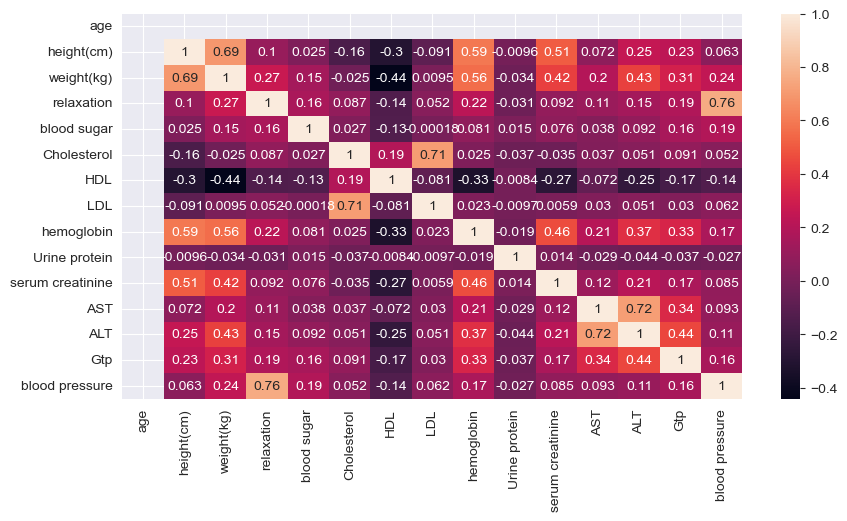

In [18]:
plt.figure(figsize=(10, 5))
sns.heatmap(data.drop(columns=['triglyceride','dental caries'])
            .corr(), annot=True)

In [37]:
data.drop(columns=['ALT','AST','LDL','Cholesterol'], inplace=True)
data

,age,height(cm),weight(kg),relaxation,blood sugar,triglyceride,HDL,hemoglobin,Urine protein,serum creatinine,Gtp,dental caries,blood pressure
0,NaN,180.0,65.0,70.0,NaN,NaN,NaN,13.9,1.0,NaN,NaN,0,112.0
1,46.0,150.0,50.0,88.0,92.0,2.0,NaN,13.2,NaN,0.6,NaN,0,138.0
2,71.0,175.0,75.0,NaN,NaN,3.0,50.0,NaN,1.0,0.8,NaN,0,137.0
3,41.0,160.0,NaN,NaN,100.0,1.0,48.0,12.1,1.0,0.6,14.0,0,133.0
4,41.0,170.0,NaN,68.0,99.0,2.0,NaN,13.8,1.0,0.9,11.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,180.0,75.0,69.0,100.0,0.0,76.0,14.7,NaN,0.8,73.0,0,120.0
9996,NaN,160.0,NaN,72.0,100.0,3.0,NaN,15.3,1.0,0.7,91.0,0,110.0
9997,36.0,165.0,65.0,72.0,83.0,NaN,65.0,NaN,1.0,0.9,23.0,0,128.0
9998,NaN,160.0,75.0,82.0,88.0,1.0,63.0,14.4,1.0,0.9,64.0,0,121.0


## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [20]:
data.isnull().sum() / len(data) * 100

age                 26.88
height(cm)          26.27
weight(kg)          25.56
relaxation          25.75
blood sugar         25.62
triglyceride        13.56
HDL                 26.09
hemoglobin          25.83
Urine protein       25.25
serum creatinine    25.67
Gtp                 25.89
dental caries        0.00
blood pressure      25.23
dtype: float64

## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts. To achieve this use the `missingno` library.

<Axes: >

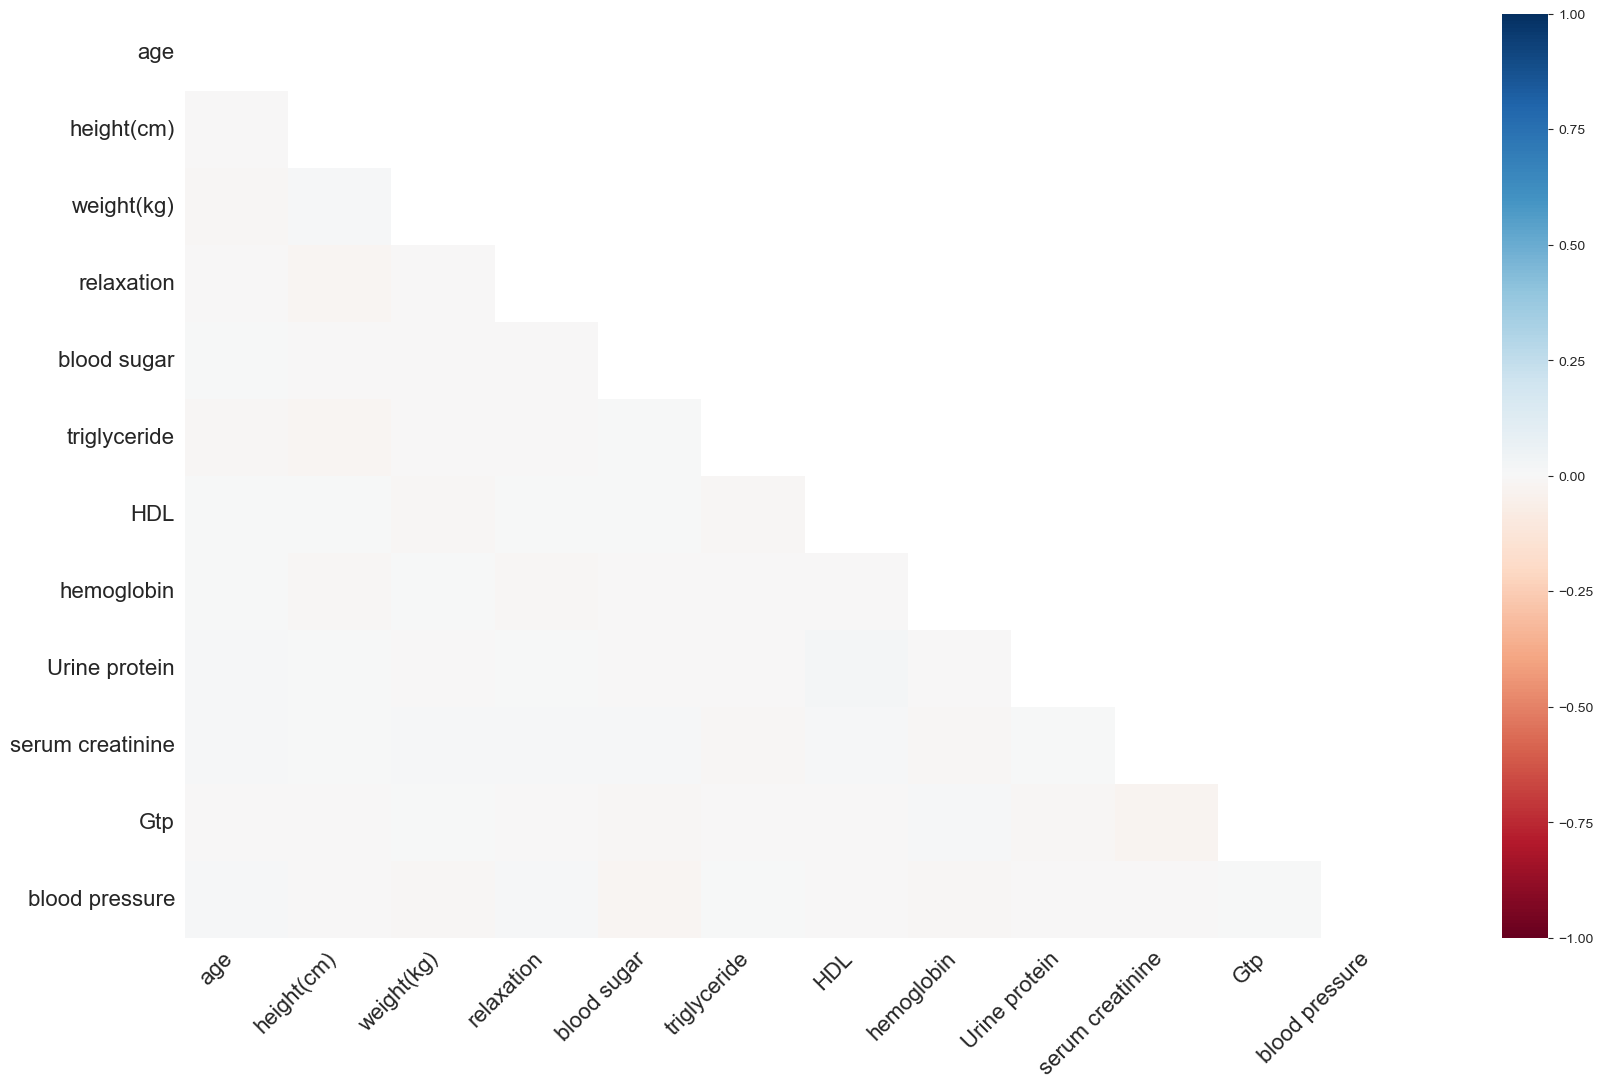

In [21]:
msno.heatmap(data)

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [22]:
def simple_impute_data(data: pd.DataFrame, columns: list, strategy: str):
    imputer = SimpleImputer(strategy=strategy)
    data_copy = data.copy()
    for column in columns:
        data_copy[column] = imputer.fit_transform(data_copy[[column]])
    return data_copy


def drop_data(data: pd.DataFrame, columns: list):
    data_copy = data.copy()
    data_copy.drop(columns, axis=1, inplace=True)
    return data_copy


def knn_impute_data(data: pd.DataFrame, columns: list, n_neighbors: int):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data_copy = data.copy()
    for column in columns:
        data_copy[column] = imputer.fit_transform(data_copy[column].to_numpy().reshape(-1, 1))
    return data_copy

In [23]:
data.isnull().sum() / len(data.columns)

age                 206.769231
height(cm)          202.076923
weight(kg)          196.615385
relaxation          198.076923
blood sugar         197.076923
triglyceride        104.307692
HDL                 200.692308
hemoglobin          198.692308
Urine protein       194.230769
serum creatinine    197.461538
Gtp                 199.153846
dental caries         0.000000
blood pressure      194.076923
dtype: float64

In [25]:
def visualize(data: pd.DataFrame, columns: list):
    for column in columns:
        sns.displot(data[column], kde=True, bins=15)
        plt.show()

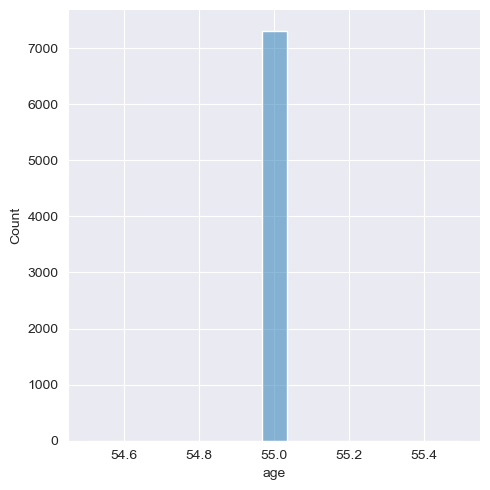

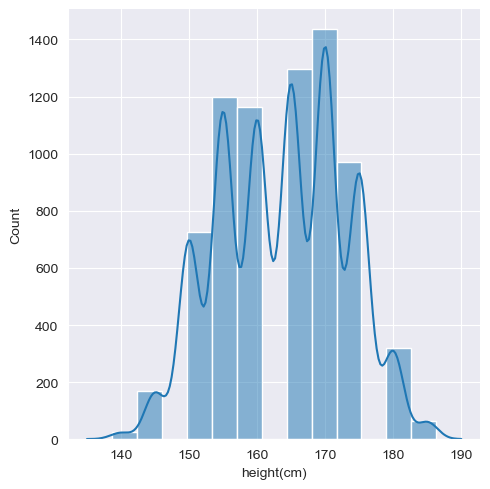

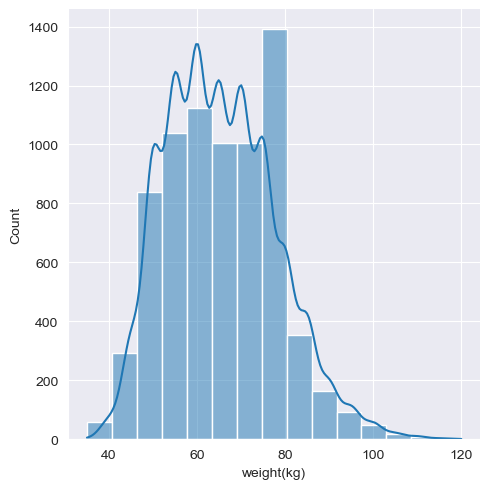

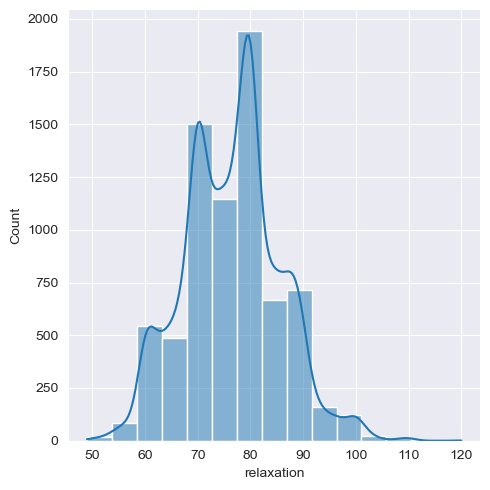

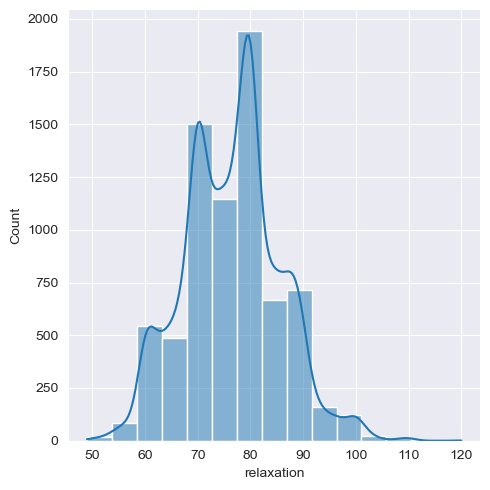

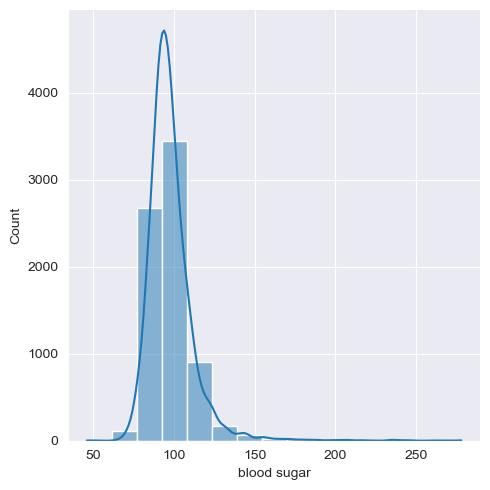

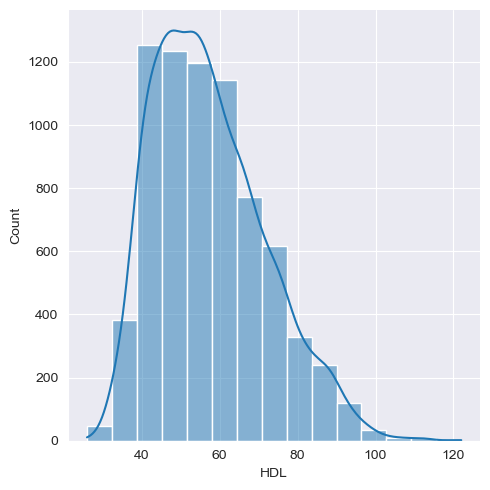

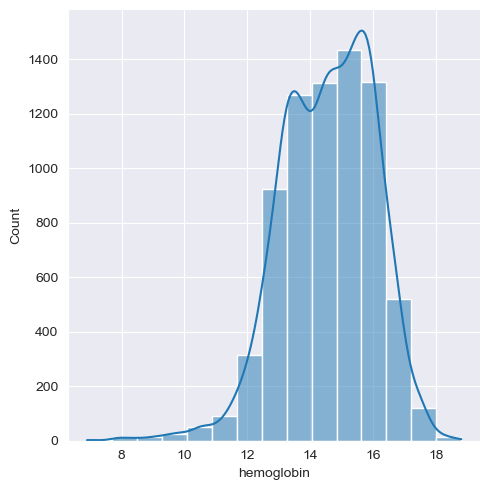

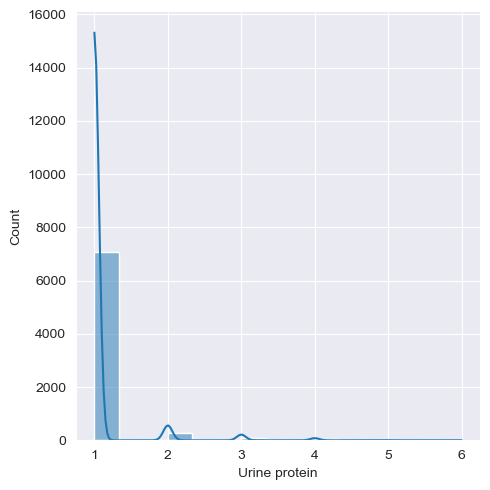

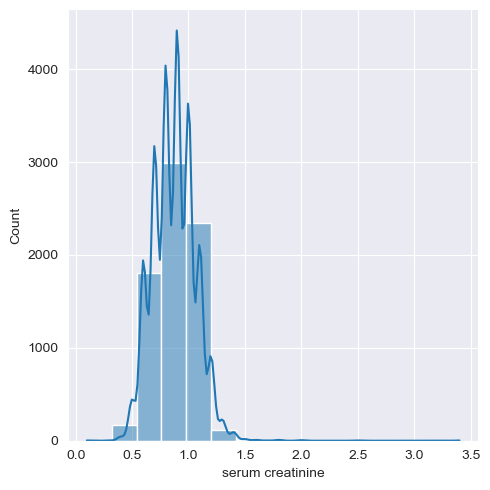

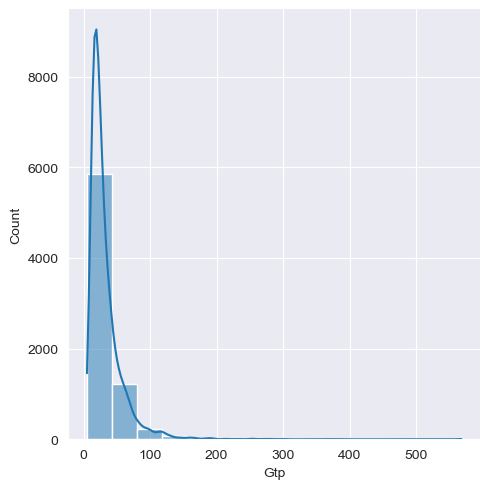

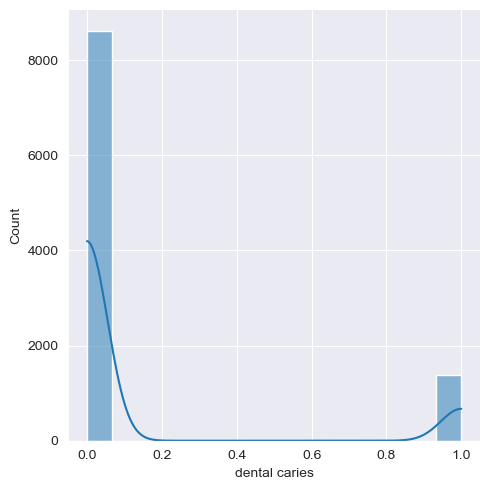

In [28]:
visualize(data,['age', 'height(cm)', 'weight(kg)', 'relaxation','relaxation', 'blood sugar', 'HDL',  'hemoglobin', 'Urine protein', 'serum creatinine',  'Gtp', 'dental caries'])

## Feature Preprocessing


Preprocess the features to make them ready for using the model

In [38]:
data = knn_impute_data(data,['age', 'height(cm)', 'weight(kg)', 'relaxation', 'blood sugar', 'triglyceride', 'Urine protein',
                        'serum creatinine', 'Gtp', 'dental caries'], 3)
data = simple_impute_data(data, ['HDL', 'hemoglobin', 'relaxation'], 'mean')

data.dropna(subset=['blood pressure'], axis=0, inplace=True)

In [44]:
data.isnull().sum() / len(data.columns)

age                 0.0
height(cm)          0.0
weight(kg)          0.0
relaxation          0.0
blood sugar         0.0
triglyceride        0.0
HDL                 0.0
hemoglobin          0.0
Urine protein       0.0
serum creatinine    0.0
Gtp                 0.0
dental caries       0.0
blood pressure      0.0
dtype: float64

## Model comparison with cross-validation

Train two models: XGBoost and RandomForest for predicting the target variable. Use 5-fold cross-validation to evaluate the performance of the models and compare them using adrquate metrics.

In [46]:
X = data.drop('blood pressure', axis=1)
Y = data['blood pressure']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


param_grid1 = {'n_estimators': [50, 100, 150],
               'learning_rate': [0.01, 0.1, 0.15, 0.25],
               'max_depth': [3, 5, 7],
               }
param_grid2 = {'n_estimators': [50, 100, 150],
               'max_depth': [3, 5, 7],
               }

rkf = KFold(n_splits=5)
gsXGB = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid1,cv=rkf)
gsRF = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid2, cv=rkf)

gsXGB.fit(X_train, Y_train)
gsRF.fit(X_train, Y_train)
    

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [47]:
print(gsXGB.best_estimator_)
print(gsRF.best_estimator_)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
RandomForestRegressor(max_depth=7, n_estimators=150)


# Cross-Validation

In [48]:
predictions1 = gsXGB.best_estimator_.predict(X_test)
predictions2 = gsRF.best_estimator_.predict(X_test)

Assess the performance of the models by using different metrics provided by the `scikit-learn` library.

In [52]:
print(r2_score(Y_test, predictions1))
print(r2_score(Y_test, predictions2))

0.45863154260093086
0.46153116351003776


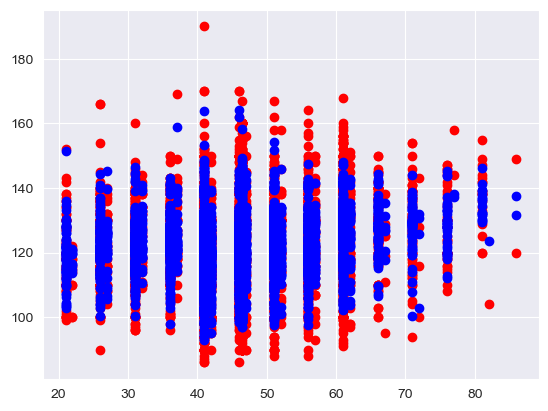

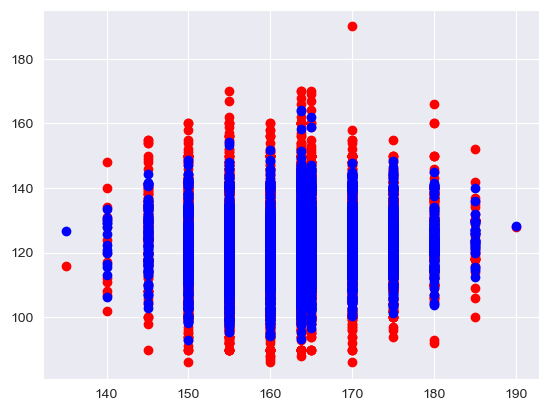

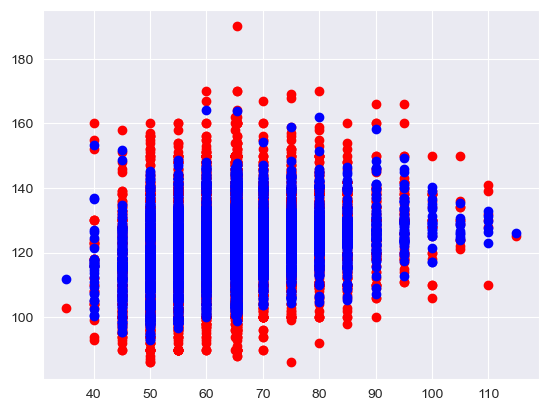

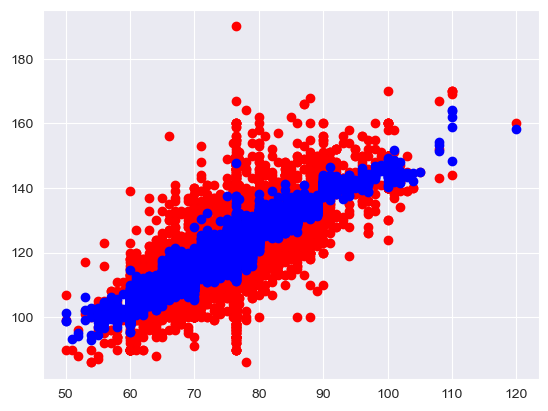

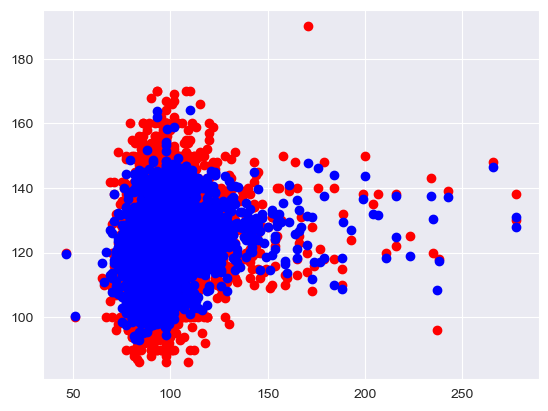

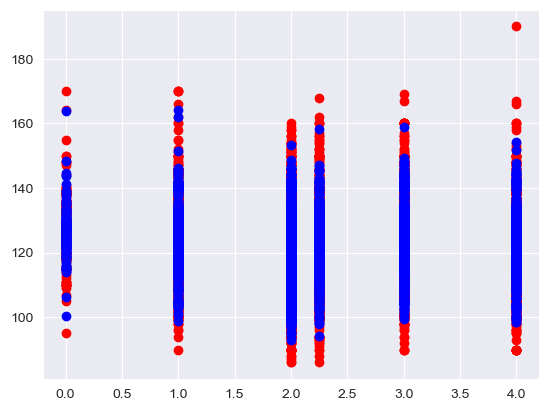

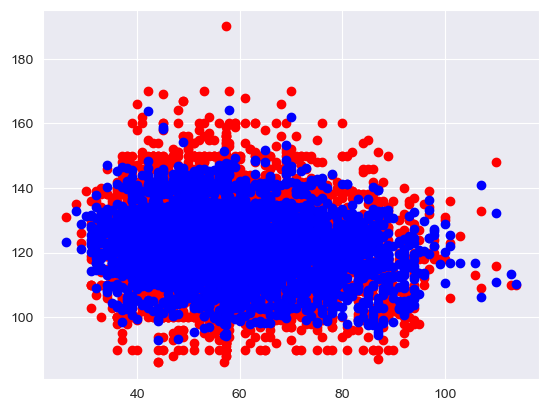

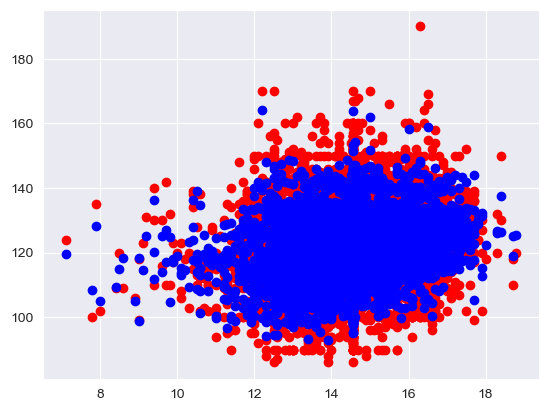

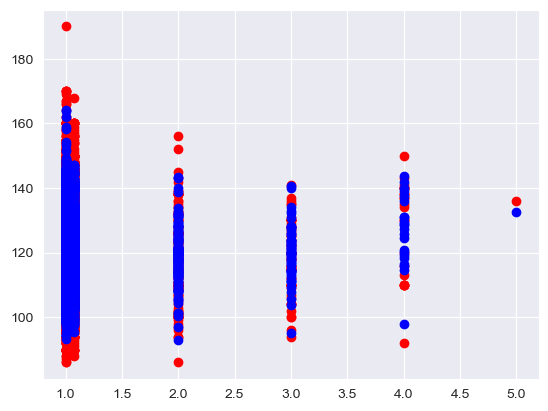

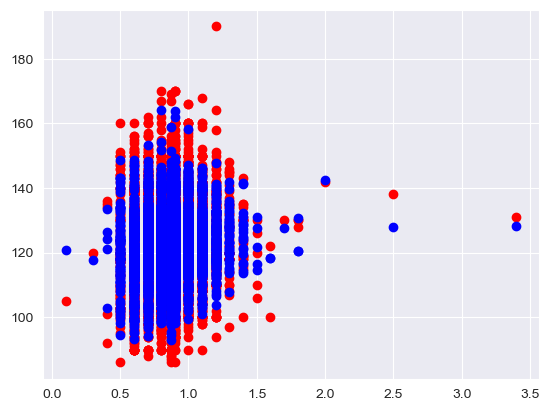

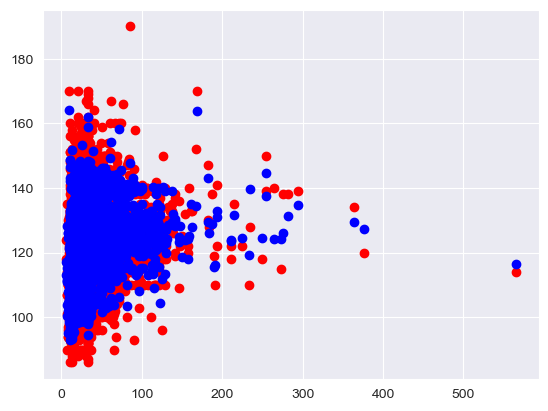

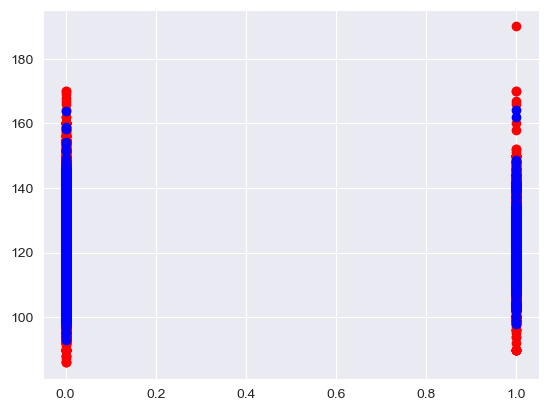

In [54]:
for col in X_train.columns:
    plt.scatter(X_train[col].to_list(), Y_train, color = 'red')
    plt.scatter(X_train[col].to_list(), gsXGB.predict(X_train), color = 'blue')
    plt.show()